In [93]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
path = '../logs/version5/checkpoints/model.pth'
model = torch.load(path)
mode = model.to('cuda')
# x = [module for module in model.modules() if not isinstance(module, nn.Sequential)]
# target_layers = [model.Mixed_7c]# inception
# target_layers = [model.features] # VGG
# target_layers = [model.layer4[-1]] # resnet
target_layers = [model.layers.maxpool5] # DRNet-Qv2
# target_layers = [model.stage4.layers[0][1].mlp_block.fn.norm] #Swin-Transformer
# target_layers = [model.levels[-1].blocks[-1].norm1] # NAT
# print(target_layers)


1


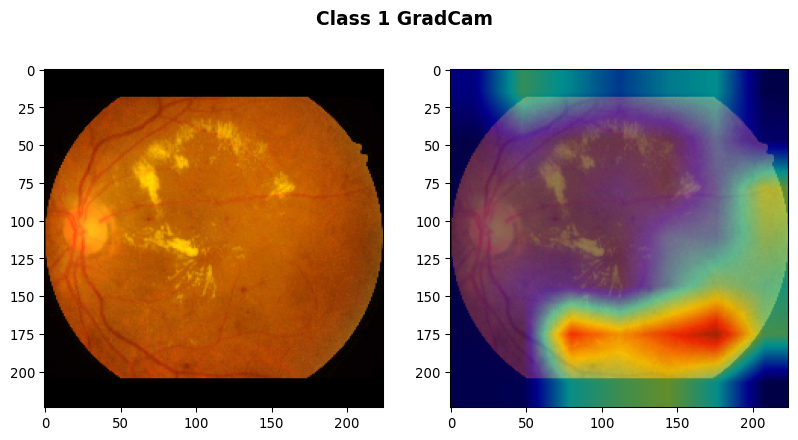

In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def reshape_transform(tensor):
    result = tensor.transpose(2, 3).transpose(1, 2)
    return result

rgb = cv2.imread('../dataset/PulbicDatasets/full/Crop/Images/IDRiD_348.jpg')
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
rgb = cv2.resize(rgb, (224,224))
rgb = np.array(rgb) / 255.

image = rgb.transpose(2, 0, 1)
image = np.expand_dims(image, axis=0)

input_tensor = torch.Tensor(image).to('cuda')
pred = model(input_tensor)
pred = torch.softmax(pred, dim=1)
pred = torch.argmax(pred).item()
print(pred)

# cam = GradCAM(model, target_layers, use_cuda=True, reshape_transform=reshape_transform)
cam = GradCAM(model, target_layers, use_cuda=True)
rgb = input_tensor.detach().cpu()
grayscale_cam = cam(input_tensor=rgb, targets=None)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb.squeeze(0).numpy().transpose(1, 2, 0), grayscale_cam, use_rgb=True)
vis_img = Image.fromarray(visualization).convert('RGB')
vis_tensor = torch.tensor(visualization.transpose(2, 0, 1), dtype=torch.float, device='cuda')

fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=96)
ax[0].imshow(rgb.squeeze(0).numpy().transpose(1, 2, 0))
ax[1].imshow(np.array(vis_img))
plt.show()


1


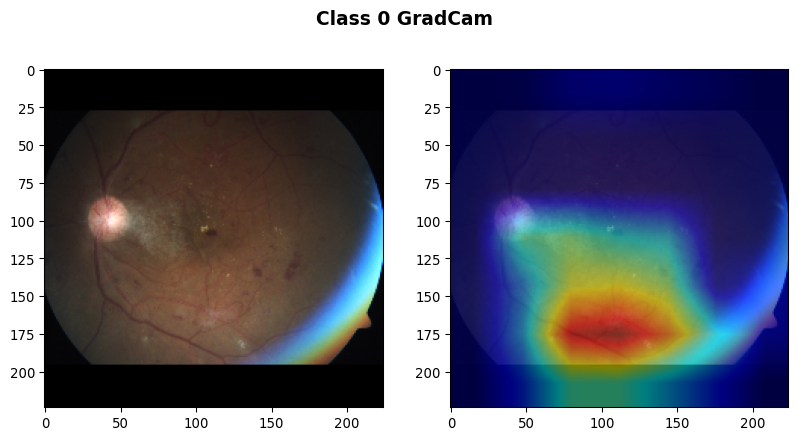

In [95]:
# rgb = cv2.imread('../dataset/D2/test/0/4627_right.jpeg')
rgb = cv2.imread('../dataset/PulbicDatasets/full/Crop/Images/0ada12c0e78f.png')
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
rgb = cv2.resize(rgb, (224,224))
rgb = np.array(rgb) / 255.

image = rgb.transpose(2, 0, 1)
image = np.expand_dims(image, axis=0)

input_tensor = torch.Tensor(image).to('cuda')
pred = model(input_tensor)
pred = torch.softmax(pred, dim=1)
pred = torch.argmax(pred).item()
print(pred)
# cam = GradCAM(model, target_layers, use_cuda=True, reshape_transform=reshape_transform)
cam = GradCAM(model, target_layers, use_cuda=True)
rgb = input_tensor.detach().cpu()
grayscale_cam = cam(input_tensor=rgb, targets=None)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb.squeeze(0).numpy().transpose(1, 2, 0), grayscale_cam, use_rgb=True)
vis_img = Image.fromarray(visualization).convert('RGB')
vis_tensor = torch.tensor(visualization.transpose(2, 0, 1), dtype=torch.float, device='cuda')

fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=96)
ax[0].imshow(rgb.squeeze(0).numpy().transpose(1, 2, 0))
ax[1].imshow(np.array(vis_img))
plt.show()



0.9607843137254902 0.98 0.96
0.9832775919732442 0.98 0.9833333333333333
0.9832775919732442 0.98 0.9833333333333333
0.9832775919732442 0.98 0.9833333333333333
0.904320987654321 0.9766666666666667 0.8966666666666666
0.98 0.98 0.98
0.7908847184986595 0.9833333333333333 0.74
0.9795918367346939 0.96 0.98
0.9832214765100671 0.9766666666666667 0.9833333333333333


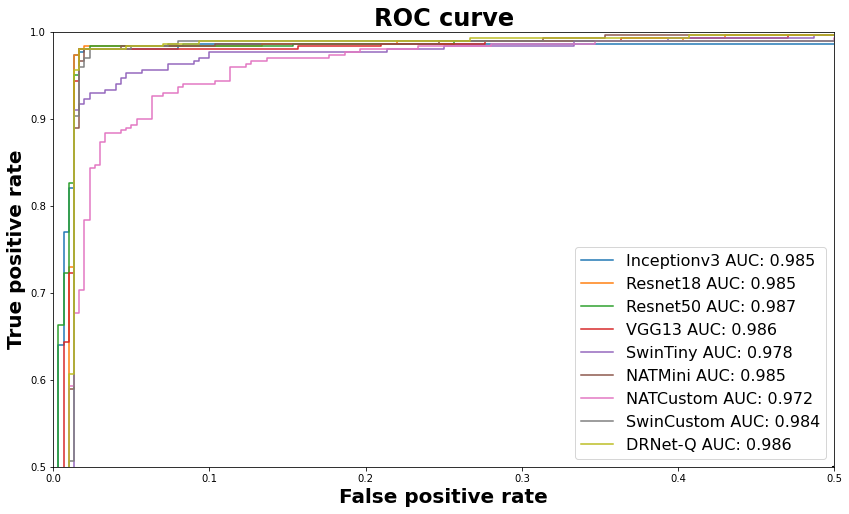

In [97]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from torchvision import datasets, transforms
import os
from sklearn.metrics import roc_curve, auc

def plot_confusion_matrix(net, loader, device):
    net.eval()
    y_pred = []  # save predction
    y_true = []  # save ground truth
    y_probas = []  # save probabilities
    # loop = tqdm(loader, ncols=120)
    for _, (inputs, labels) in enumerate(loader):
        inputs = inputs.type(torch.float).to(device)
        labels = labels.type(torch.long).to(device)
        output = net(inputs)  # Feed Network
        probas = torch.softmax(output, dim=1).detach().cpu().numpy()
        # print(probas[:, 1])
        y_probas.append(probas[:, 1]) # save probabilities
        output = (np.argmax(probas))
        y_pred.append(output)  # save prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth
    # constant for classes
    classes = ('Low-Quality', 'High-Quality')
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cf_matrix.ravel()

    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    precision = tp / (tp+fp)
    print(precision, sensitivity, specificity)

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    
    # plt.figure(figsize=(8, 6))
    # ax = sns.heatmap(cf_matrix, annot=labels, cmap='Oranges', fmt='', annot_kws={"size": 22},)
    # ax.xaxis.set_ticklabels(['Low Quality', 'High Quality'], fontsize=22)
    # ax.yaxis.set_ticklabels(['Low Quality', 'High Quality'], fontsize=22)
    # ax.set_xlabel('CNN label', fontsize=22, fontweight="bold")
    # ax.set_ylabel('Human Opinion', fontsize=22, fontweight="bold")
    # ax.set_title('Test dataset', fontsize=24, fontweight="bold")
    # plt.savefig('../images/test_cfmatrix.png')
    return y_true, y_probas

def roc_auc_plot(y_true, y_probas, name):
    fpr, tpr, thresholds_keras = roc_curve(y_true, y_probas)
    auc_score = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.plot(fpr, tpr, '-', label=name + ' AUC: {:.3f}'.format(auc_score), linewidth=1.5)

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder(
    '../dataset/D2/test/', transform=test_transforms
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
plt.figure(figsize=(14,8))
path = '../logs/version0/checkpoints/model.pth'
model2 = torch.load(path)
y_true, y_probas = plot_confusion_matrix(model2, test_loader, 'cuda')
roc_auc_plot(y_true, y_probas, 'Inceptionv3')
path = '../logs/version1/checkpoints/model.pth'
model2 = torch.load(path)
y_true, y_probas = plot_confusion_matrix(model2, test_loader, 'cuda')
roc_auc_plot(y_true, y_probas, 'Resnet18')
path = '../logs/version2/checkpoints/model.pth'
model2 = torch.load(path)
y_true, y_probas = plot_confusion_matrix(model2, test_loader, 'cuda')
roc_auc_plot(y_true, y_probas, 'Resnet50')
path = '../logs/version3/checkpoints/model.pth'
model2 = torch.load(path)
y_true, y_probas = plot_confusion_matrix(model2, test_loader, 'cuda')
roc_auc_plot(y_true, y_probas, 'VGG13')
path = '../logs/version4/checkpoints/model.pth'
model2 = torch.load(path)
y_true, y_probas = plot_confusion_matrix(model2, test_loader, 'cuda')
roc_auc_plot(y_true, y_probas, 'SwinTiny')
path = '../logs/version7/checkpoints/model.pth'
model2 = torch.load(path)
y_true, y_probas = plot_confusion_matrix(model2, test_loader, 'cuda')
roc_auc_plot(y_true, y_probas, 'NATMini')
path = '../logs/version9/checkpoints/model.pth'
model2 = torch.load(path)
y_true, y_probas = plot_confusion_matrix(model2, test_loader, 'cuda')
roc_auc_plot(y_true, y_probas, 'NATCustom')
path = '../logs/version6/checkpoints/model.pth'
model2 = torch.load(path)
y_true, y_probas = plot_confusion_matrix(model2, test_loader, 'cuda')
roc_auc_plot(y_true, y_probas, 'SwinCustom')
path = '../logs/version5/checkpoints/model.pth'
model2 = torch.load(path)
y_true, y_probas = plot_confusion_matrix(model2, test_loader, 'cuda')
roc_auc_plot(y_true, y_probas, 'DRNet-Q')
plt.xlabel('False positive rate', fontsize=20, fontweight='bold')
plt.ylabel('True positive rate', fontsize=20, fontweight='bold')
plt.title('ROC curve', fontsize=24, fontweight='bold')
plt.ylim([0.5, 1])
plt.xlim([0, 0.5])
plt.legend(loc='best', prop={'size': 16})
plt.show()